**Ho va ten: Do Khanh Dang Khoa**

**MSSV: 19110348**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
#Loading a dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#Check số lượng labels
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


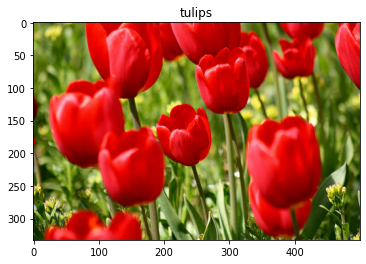

In [ ]:
#Show thử một số ảnh. ra
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 180
#Định nghĩa hàm resizing và rescaling
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

1. Hãy thêm một số phương pháp augmentations khác cho model:

In [ ]:
#Định nghĩa 2 augmentations là random flip và random random rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2), #Điều chỉnh độ sáng của ảnh trong khoảng -1.0 tới 1.0
  tf.keras.layers.RandomZoom(height_factor = (0.2, 0.3)) #kết quả đầu ra được thu nhỏ một cách ngẫu nhiên trong phạm vi [+ 20%, + 30%]
])

In [ ]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

2. Hãy thay model VGG16 thành VGG 19 và train thử 

In [ ]:
def create_model():

    pretrained_model = pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    last_output = pretrained_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(250, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=pretrained_model.input, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model
model = create_model()
MC=tf.keras.callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True, 
    verbose=1
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[MC]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - ETA: 0s - loss: 2.1792 - accuracy: 0.2292
Epoch 1: val_accuracy improved from -inf to 0.24251, saving model to best.hdf5
23/23 [==============================] - 92s 3s/step - loss: 2.1792 - accuracy: 0.2292 - val_loss: 1.6023 - val_accuracy: 0.2425
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6081 - accuracy: 0.2398
Epoch 2: val_accuracy did not improve from 0.24251
23/23 [==============================] - 46s 2s/step - loss: 1.6081 - accuracy: 0.2398 - val_loss: 1.6053 - val_accuracy: 0.2425
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.6038 - accuracy: 0.2432
Epoch 3: val_accuracy did not improve from 0.24251
23/23 [==============================] - 46s 2s/step - loss: 1.6038 - accuracy: 0.2432 - val_loss: 1.5983 - val_accuracy: 0.2425
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.6030 - accuracy: 0.2510
Epoch 4: val_accuracy did not improve from 0.24251
23/23 [=========

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 2s 427ms/step - loss: 1.6140 - accuracy: 0.1907


[1.6140103340148926, 0.19073569774627686]

Freezing pre-trained model

In [ ]:
def create_model_freeze():

    pretrained_model = pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    pretrained_model.trainable = False
    last_output = pretrained_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(250, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=pretrained_model.input, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model
model_freeze = create_model_freeze()
MC=tf.keras.callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True, 
    verbose=1
)
model_freeze.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history =model_freeze.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[MC]
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.6225 - accuracy: 0.2367
Epoch 1: val_accuracy improved from -inf to 0.31608, saving model to best.hdf5
23/23 [==============================] - 29s 1s/step - loss: 1.6225 - accuracy: 0.2367 - val_loss: 1.5849 - val_accuracy: 0.3161
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5890 - accuracy: 0.2650
Epoch 2: val_accuracy improved from 0.31608 to 0.32970, saving model to best.hdf5
23/23 [==============================] - 28s 1s/step - loss: 1.5890 - accuracy: 0.2650 - val_loss: 1.5217 - val_accuracy: 0.3297
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.5786 - accuracy: 0.2684
Epoch 3: val_accuracy improved from 0.32970 to 0.34605, saving model to best.hdf5
23/23 [==============================] - 28s 1s/step - loss: 1.5786 - accuracy: 0.2684 - val_loss: 1.4881 - val_accuracy: 0.3460
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.5501 - accuracy: 0

In [ ]:
model_freeze.evaluate(test_ds)

3/3 [==============================] - 2s 461ms/step - loss: 0.9939 - accuracy: 0.6485


[0.9939386248588562, 0.6485013365745544]

Khi đổi số epochs = 10 cho cả freezing và unfreezing thì ta có được accuracy với unfreezing là 19% thấp hơn hẳn so với freezing là 65%